# Models using all variables

In [5]:
import pandas as pd
import numpy as np

X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std_perf.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std_perf.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train_perf.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test_perf.csv")

Y values to array

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
other_y_train = np.ravel(y_train)
other_y_test = np.ravel(y_test)

In [8]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
import numpy as np

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Lineal regression models

In [10]:
X_train_std = X_train_std.drop(["index", "ID_Zenodo"], axis=1)

X_test_std = X_test_std.drop(["index", "ID_Zenodo"], axis=1)

### Lineal Regression

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=10, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

lr_mse_train = mean_squared_error(y_train, lr.predict(X_train_std))
lr_mse_test = mean_squared_error(y_test, lr.predict(X_test_std))

In [12]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")

R2 train: 0.3194458686307047
R2 val: 0.28118651152795227
R2 test: 0.2836956115627042


In [13]:
print(f"MSE train: {lr_mse_train}")
print(f"MSE test: {lr_mse_test}")

MSE train: 0.680554131369295
MSE test: 0.783411345144535


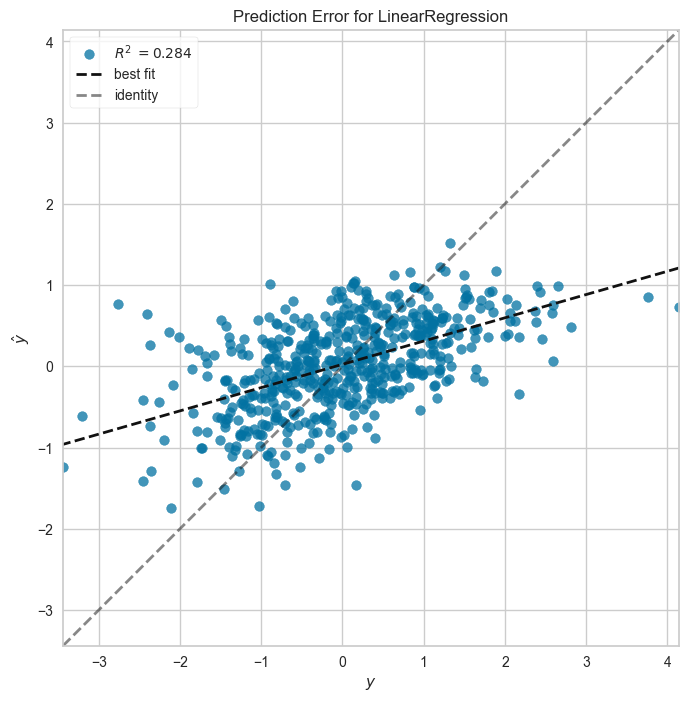

In [14]:
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

In [15]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV( scoring="r2", cv=10).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV( scoring="r2", cv=10), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.3205805700198089
Validation R2:  0.2869780934161992
Test R2:  0.28375298070340405
10.0


In [16]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=10.0, solver="saga").fit(X_train_std, other_y_train)
clf.score(X_test_std, other_y_test)

0.2837561012393086

### Lasso Regression

In [17]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.3157212502510993
Validation R2:  0.28743617498571294
Test R2:  0.27943700846653574
0.008135293759221052


### ElasticNet

In [18]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import ElasticNetCV
elasticnet_cv = ElasticNetCV(cv=5, random_state=0).fit(X_train_std, y_train)
elasticnet_r2_test= elasticnet_cv.score(X_test_std, y_test)
elasticnet_r2_val = np.mean(cross_val_score( ElasticNetCV(random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
elasticnet_r2_train= elasticnet_cv.score(X_train_std, y_train)

print("Train R2: ", elasticnet_r2_train)
print("Validation R2: ", elasticnet_r2_val)
print("Test R2: ", elasticnet_r2_test)
print(elasticnet_cv.alpha_)

Train R2:  0.31585314127375164
Validation R2:  0.28715064199956275
Test R2:  0.27943383679916756
0.015174004375455446


In [19]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train, 'Elasticnet': elasticnet_r2_train}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val, elasticnet_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test, elasticnet_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results.loc['lambda','Elasticnet']=elasticnet_cv.alpha_
r2_results


[0.28118651152795227, 0.2869780934161992, 0.28743617498571294]


,LR,Ridge,Lasso,Elasticnet
Train R2,0.319446,0.320581,0.315721,0.315853
CV (Val) R2,0.281187,0.286978,0.287436,0.287151
Test R2,0.283696,0.283753,0.279437,0.279434
lambda,0.000000,10.000000,0.008135,0.015174


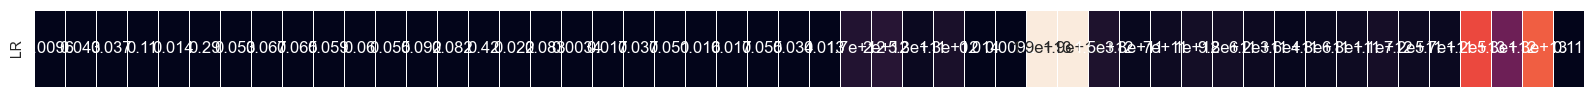

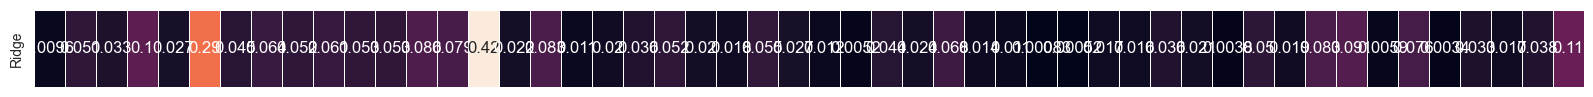

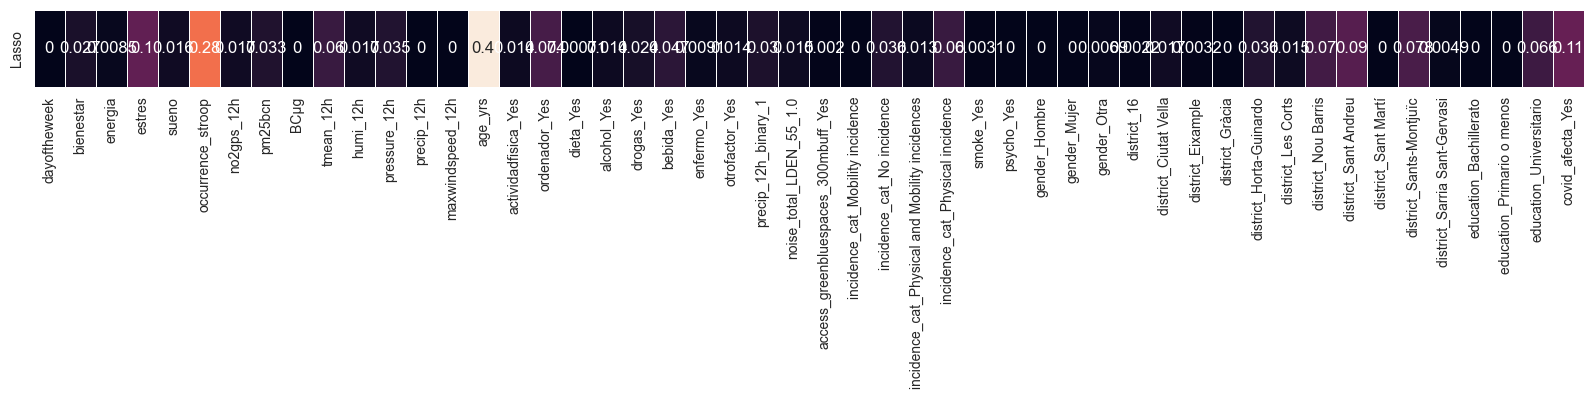

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns

weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

### Usant la llibreria Statsmodels

In [21]:
#TODO
import statsmodels
def normality(model, X, y):
  residus = y - model.predict(X)
  f, ax = plt.subplots(figsize=(6,6))
  sns.histplot(data=residus, bins=20, kde=True)
  print(statsmodels.stats.diagnostic.normal_ad(residus))

def linearity(model, X, y):
  f, ax = plt.subplots(figsize=(6,6))

  predictions = model.predict(X)
  ax.scatter(y, predictions)
  ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="red")
  plt.show()

In [22]:
import statsmodels.api as sm

X_train_std = sm.add_constant(X_train_std)  # Add intercept
X_test_std = sm.add_constant(X_test_std) 
glm_model = sm.GLM(y_train, X_train_std, family=sm.families.Gaussian()).fit()

# Print summary
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2251
Model:                            GLM   Df Residuals:                     2204
Model Family:                Gaussian   Df Model:                           46
Link Function:               Identity   Scale:                         0.70570
Method:                          IRLS   Log-Likelihood:                -2759.0
Date:                Thu, 02 May 2024   Deviance:                       1529.3
Time:                        18:01:03   Pearson chi2:                 1.53e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.3656
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

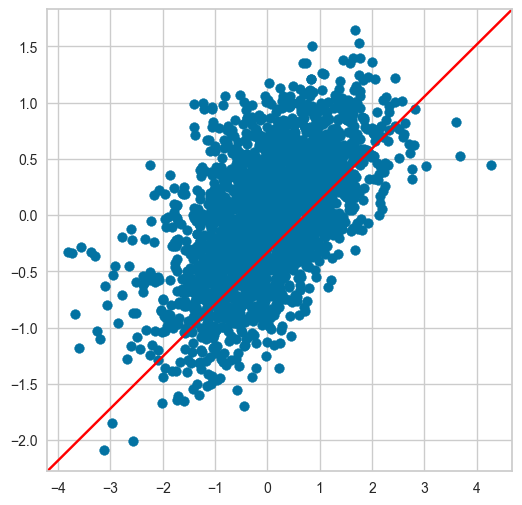

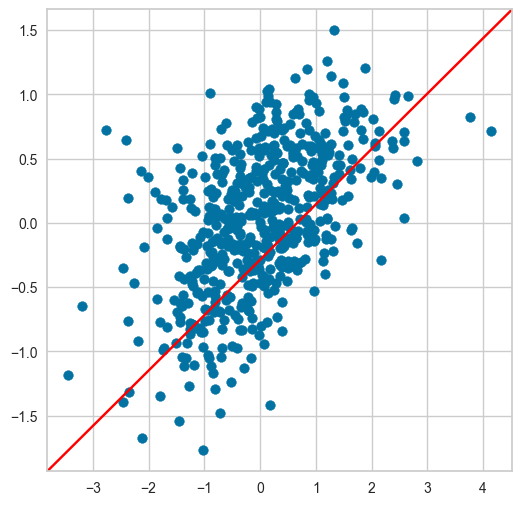

0.2838200175465829

In [23]:
glm_model.predict(X_train_std)
linearity(glm_model, X_train_std, y_train)
linearity(glm_model, X_test_std, y_test)

r2_score(y_test, glm_model.predict(X_test_std))

(1.649573992034675, 0.00031084576076158667)
(0.7355666378070964, 0.0549581524794816)


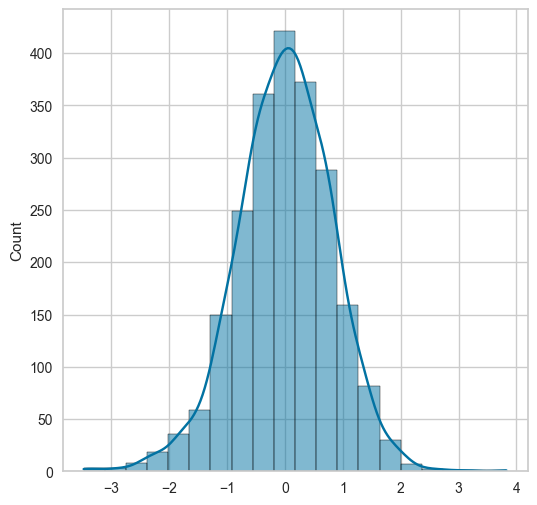

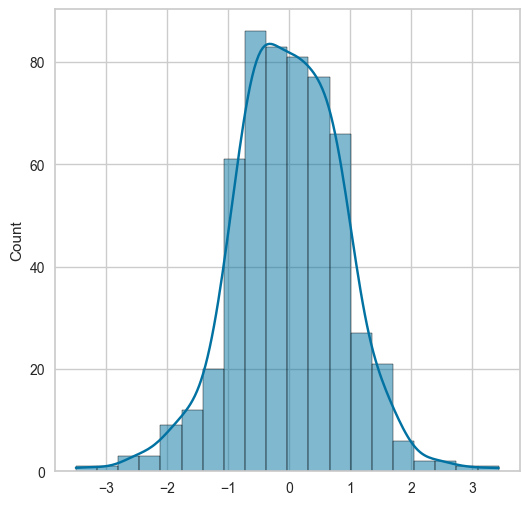

In [24]:
normality(glm_model, X_train_std, y_train)
normality(glm_model, X_test_std, y_test)

In [25]:
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
model = sm.OLS(y_test, sm.add_constant(X_test_std)).fit()
residuals = y_test - glm_model.predict(X_test_std)

# Perform Breusch-Pagan test for homoscedasticity
_, p_value, _, _ = het_breuschpagan(residuals, X_test_std)
print(f'HOMOCEDASTICITY: {p_value}, result: {"Violated" if p_value < 0.05 else "Satisfied"}')

# Assumption 4: Normality of Residuals
_, p_value = normal_ad(y_test - sm.OLS(y_test, sm.add_constant(X_test_std)).fit().fittedvalues)
print(f'NORMALITY: p-value: {p_value}, result: {"Violated" if p_value < 0.05 else "Satisfied"}')


HOMOCEDASTICITY: 0.21969703375702332, result: Satisfied
NORMALITY: p-value: 0.10319164125918859, result: Satisfied


# MLP (Multi Layer Perceptron)

In [26]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()


In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from tensorflow.keras import regularizers

In [ ]:
# Alternativament a usar K-folds cross-val, que és la sol·lució per la qual hem optat,
# es pot simplement usar el train_test_split amb la partició de train per crear
# una sola partició de validació

## First iteration

In [57]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

callback = EarlyStopping(monitor='loss',patience=3)

model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_std.shape[1],)),
    Dense(1)
])
# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', 'r2_score'])
callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

# Train the model
num_epochs = 1000
batch_size = 32
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

y_train_pred = model.predict(X_train_std)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

final_val_loss = history.history['val_r2_score'][-1]  # Final validation loss
final_val_mse = history.history['val_mean_squared_error'][-1]  # Final validation accuracy

print("Final Validation MSE:", final_val_mse)
print("Final Validation R-squared:", final_val_accuracy)

print('Training MSE: {:.4f}'.format(train_mse))
print('Training R-squared: {:.4f}'.format(train_r2))

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4759 - mean_squared_error: 1.4759 - r2_score: -0.4135 - val_loss: 0.9020 - val_mean_squared_error: 0.9020 - val_r2_score: 0.0423
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9171 - mean_squared_error: 0.9171 - r2_score: 0.0949 - val_loss: 0.7441 - val_mean_squared_error: 0.7441 - val_r2_score: 0.2100
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7502 - mean_squared_error: 0.7502 - r2_score: 0.2606 - val_loss: 0.6830 - val_mean_squared_error: 0.6830 - val_r2_score: 0.2748
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6533 - mean_squared_error: 0.6533 - r2_score: 0.3452 - val_loss: 0.6351 - val_mean_squared_error: 0.6351 - val_r2_score: 0.3257
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6209 - mean_squared_error: 0.6209 - r2_score: 0.3759 - val_loss: 0.6168 - val_mean_squared_error: 0.6168 - val_r2_score: 0.3451
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

In [ ]:
plot_curves(history)

In [42]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

In [49]:
history.

SyntaxError: invalid syntax (3854863393.py, line 1)

## Second iteration

In [31]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.95
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=15)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9048 - mean_squared_error: 1.9048 - val_loss: 0.8387 - val_mean_squared_error: 0.8387
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0675 - mean_squared_error: 1.0675 - val_loss: 0.7919 - val_mean_squared_error: 0.7919
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8674 - mean_squared_error: 0.8674 - val_loss: 0.7357 - val_mean_squared_error: 0.7357
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7690 - mean_squared_error: 0.7690 - val_loss: 0.6865 - val_mean_squared_error: 0.6865
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7831 - mean_squared_error: 0.7831 - val_loss: 0.6626 - val_mean_squared_error: 0.6626
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7129 - mean_squared_error: 0.7129 - val_loss: 0.6372 - val_mean_squared_error: 0.6372
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7182 - mean_squared_error: 0.7182 - val_loss: 0.6090 - val_mean

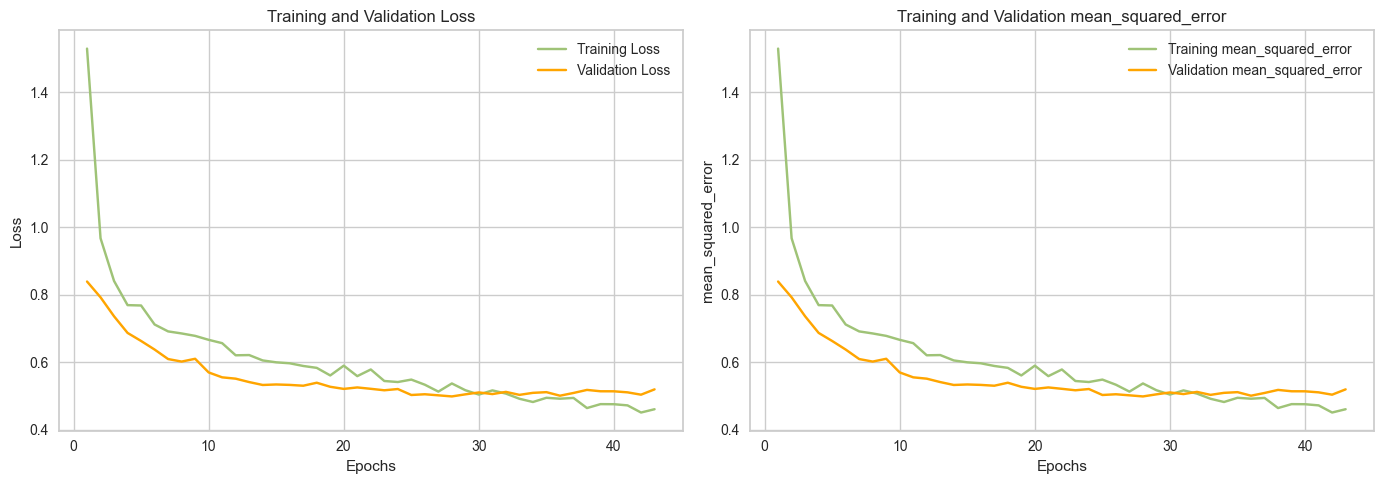

In [32]:
plot_curves(history)

## Third iteration

In [33]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.7),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.98
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=50)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9787 - mean_squared_error: 3.0341 - val_loss: 0.5064 - val_mean_squared_error: 1.2687
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6999 - mean_squared_error: 1.9485 - val_loss: 0.3917 - val_mean_squared_error: 0.9056
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5008 - mean_squared_error: 1.2744 - val_loss: 0.3960 - val_mean_squared_error: 0.9502
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4376 - mean_squared_error: 1.0545 - val_loss: 0.3556 - val_mean_squared_error: 0.8212
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4091 - mean_squared_error: 0.9737 - val_loss: 0.3525 - val_mean_squared_error: 0.8210
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3869 - mean_squared_error: 0.9172 - val_loss: 0.3338 - val_mean_squared_error: 0.7675
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3707 - mean_squared_error: 0.8652 - val_loss: 0.3239 - val_mean

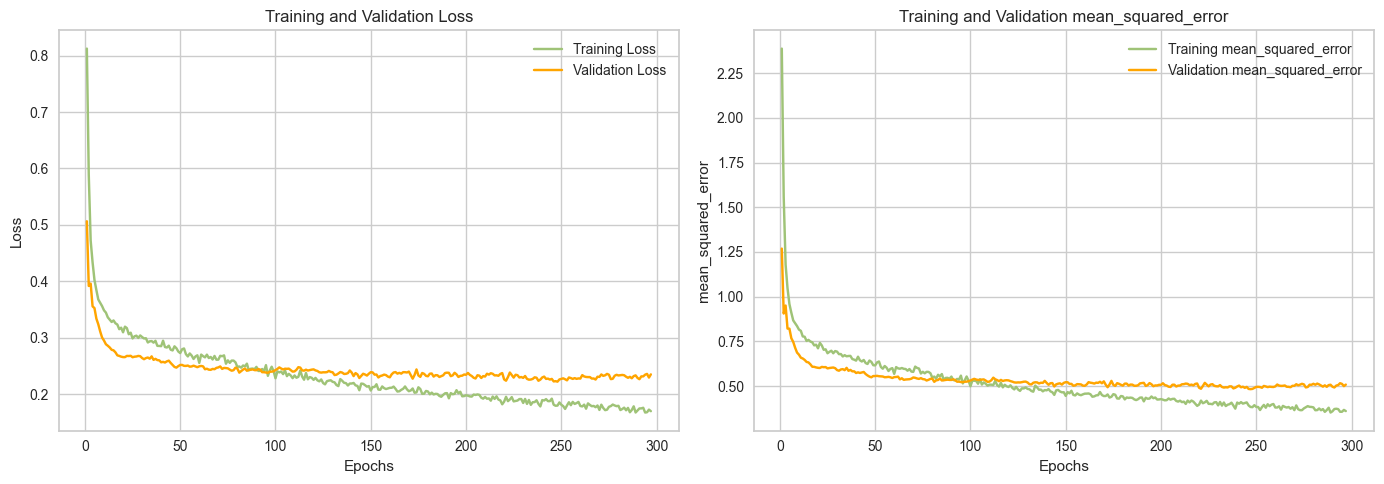

In [34]:
plot_curves(history)

## Fourth iteration

In [35]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.75),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.98
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=40)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7657 - mean_squared_error: 2.1890 - val_loss: 0.4200 - val_mean_squared_error: 0.9971
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6176 - mean_squared_error: 1.7026 - val_loss: 0.3828 - val_mean_squared_error: 0.8892
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4833 - mean_squared_error: 1.2037 - val_loss: 0.3800 - val_mean_squared_error: 0.8982
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4262 - mean_squared_error: 1.0406 - val_loss: 0.3601 - val_mean_squared_error: 0.8365
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3766 - mean_squared_error: 0.9008 - val_loss: 0.3567 - val_mean_squared_error: 0.8347
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3831 - mean_squared_error: 0.9188 - val_loss: 0.3355 - val_mean_squared_error: 0.7737
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3828 - mean_squared_error: 0.9235 - val_loss: 0.3314 - val_mea

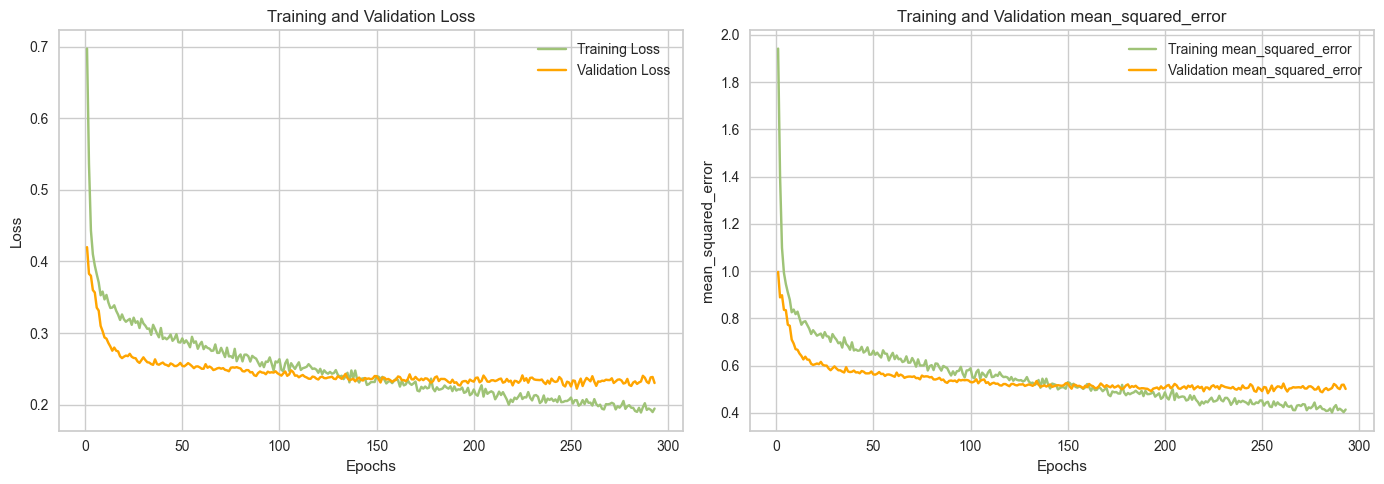

In [36]:
plot_curves(history)

### Utilitzant MLPRegressor

In [37]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(800, 800, 800, 400,), random_state=1, max_iter=500).fit(X_train_std, y_train)

regr.score(X_test_std, y_test)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.4867506732494381